# 训练CNN学习P/T波等形态

Cell 1 — 导入依赖

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt, find_peaks, resample
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


Cell 2 — 加载 PTB-XL 原始数据 (12 导联)

In [4]:
DATA_DIR = Path("../data/processed_records100_by_folder")

# 直接用整合好的 X.npy (形状 (N, 1000, 12))
X_raw = np.load(DATA_DIR / "X.npy")
print("✅ Loaded:", X_raw.shape)  # (21837, 1000, 12)


✅ Loaded: (21837, 1000, 12)


Cell 3 — R 峰检测函数（Lead II）

In [5]:
def bandpass_filter(sig, fs=100, low=5, high=20, order=3):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, sig)

def detect_r_peaks(sig, fs=100, prominence=0.6, height=0.5):
    sig_f = bandpass_filter(sig, fs)
    sig_z = (sig_f - np.mean(sig_f)) / (np.std(sig_f) + 1e-6)
    peaks, _ = find_peaks(sig_z, distance=int(0.5*fs), prominence=prominence, height=height)
    return peaks


Cell 4 — 从单条记录中切出单心搏

In [6]:
def resample_1d(x, target_len=188):
    xi = np.linspace(0, 1, num=len(x))
    xo = np.linspace(0, 1, num=target_len)
    return np.interp(xo, xi, x)

def extract_beats_from_record(rec, fs=100, lead_idx=1, pre_s=0.28, post_s=0.56, target_len=188):
    """从单条记录 (1000, 12) 提取单心搏段"""
    sig = rec[:, lead_idx]
    peaks = detect_r_peaks(sig, fs=fs)
    pre = int(pre_s * fs)
    post = int(post_s * fs)
    beats = []
    for p in peaks:
        a, b = p - pre, p + post
        if a >= 0 and b <= len(sig):
            beat = sig[a:b]
            beat_rs = resample_1d(beat, target_len)
            beats.append(beat_rs)
    return np.array(beats)[:, :, None] if len(beats) > 0 else np.empty((0, target_len, 1))

# 测试一条记录
test_beats = extract_beats_from_record(X_raw[0])
print("单条记录心搏数:", len(test_beats))
print("单心搏形状:", test_beats.shape)


单条记录心搏数: 9
单心搏形状: (9, 188, 1)


In [7]:
all_beats = []
for i, rec in enumerate(X_raw):
    beats = extract_beats_from_record(rec, lead_idx=1)
    if beats.size > 0:
        all_beats.append(beats)
    if i % 500 == 0:
        print(f"Processed {i}/{len(X_raw)} records...")

X_beats = np.concatenate(all_beats, axis=0)
print("✅ 完成心搏提取:", X_beats.shape)   # (M, 188, 1)
np.save("../data/ecg_beats_188.npy", X_beats)


Processed 0/21837 records...
Processed 500/21837 records...
Processed 1000/21837 records...
Processed 1500/21837 records...
Processed 2000/21837 records...
Processed 2500/21837 records...
Processed 3000/21837 records...
Processed 3500/21837 records...
Processed 4000/21837 records...
Processed 4500/21837 records...
Processed 5000/21837 records...
Processed 5500/21837 records...
Processed 6000/21837 records...
Processed 6500/21837 records...
Processed 7000/21837 records...
Processed 7500/21837 records...
Processed 8000/21837 records...
Processed 8500/21837 records...
Processed 9000/21837 records...
Processed 9500/21837 records...
Processed 10000/21837 records...
Processed 10500/21837 records...
Processed 11000/21837 records...
Processed 11500/21837 records...
Processed 12000/21837 records...
Processed 12500/21837 records...
Processed 13000/21837 records...
Processed 13500/21837 records...
Processed 14000/21837 records...
Processed 14500/21837 records...
Processed 15000/21837 records...
P

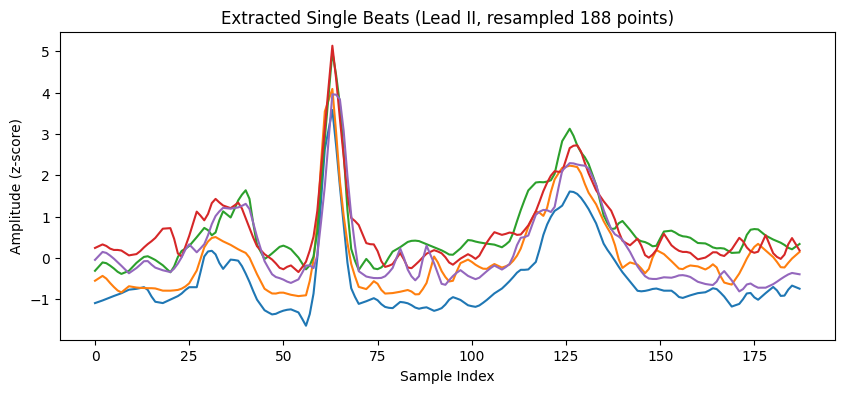

In [8]:
plt.figure(figsize=(10,4))
for i in range(5):
    plt.plot(X_beats[i,:,0])
plt.title("Extracted Single Beats (Lead II, resampled 188 points)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (z-score)")
plt.show()

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D

inp = Input(shape=(188, 1))
x = Conv1D(32, 7, activation='relu', padding='same')(inp)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(64, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same', name='encoded_layer')(x)

x = Conv1D(128, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(64, 5, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 7, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

# 输出层 + 裁剪层（关键修复点）
decoded = Conv1D(1, 3, activation='tanh', padding='same')(x)
decoded = Cropping1D(((192 - 188)//2, (192 - 188)//2))(decoded)  # 裁掉两边各 2 个采样点

autoencoder = Model(inp, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 188, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 188, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 94, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 94, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_layer (MaxPooling1D)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 24, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 48, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 96, 32)         │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 192, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 192, 1)         │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 188, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,033 (547.00 KB)

 Trainable params: 140,033 (547.00 KB)

 Non-trainable params: 0 (0.00 B)

Cell 8 — 训练 CNN 自编码器

In [11]:
autoencoder.fit(
    X_beats, X_beats,
    batch_size=64,
    epochs=40,
    validation_split=0.2,
    verbose=1
)


Epoch 1/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 136s 45ms/step - loss: 0.3088 - val_loss: 0.3253
Epoch 2/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - loss: 0.3079 - val_loss: 0.3249
Epoch 3/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - loss: 0.3077 - val_loss: 0.3248
Epoch 4/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 138s 46ms/step - loss: 0.3076 - val_loss: 0.3247
Epoch 5/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 138s 45ms/step - loss: 0.3075 - val_loss: 0.3247
Epoch 6/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 138s 45ms/step - loss: 0.3075 - val_loss: 0.3246
Epoch 7/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 142s 47ms/step - loss: 0.3074 - val_loss: 0.3246
Epoch 8/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 180s 59ms/step - loss: 0.3074 - val_loss: 0.3246
Epoch 9/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 181s 60ms/step - loss: 0.3074 - val_loss: 0.3246
Epoch 10/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 185s 61ms/step - loss: 0.3074 - val_loss: 0.3245
Epoch 11/40
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 188s 62ms/step - loss: 0.3074 - val_loss: 0.32

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


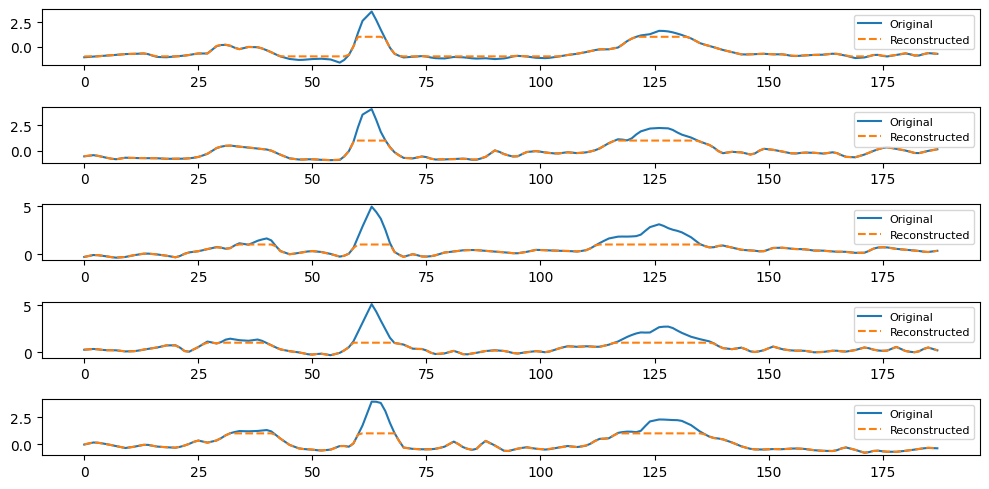

In [12]:
# Cell 9: 可视化原始 vs 重建波形
decoded_samples = autoencoder.predict(X_beats[:5])

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(X_beats[i,:,0], label='Original')
    plt.plot(decoded_samples[i,:,0], label='Reconstructed', linestyle='--')
    plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


四、下一步（Cell 10）
从自编码器中取出 encoded_layer 输出作为「CNN 表征特征」，
再将它映射到你 MLP 的输入维度（187）。

In [13]:
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# 取出编码层输出
encoder = Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("encoded_layer").output)
features = encoder.predict(X_beats, batch_size=64)

print("Encoded 特征维度:", features.shape)   # 例如 (M, 23, 128)

# 拉平并归一化
f_flat = features.reshape(features.shape[0], -1)
scaler = StandardScaler()
f_scaled = scaler.fit_transform(f_flat)

# 截取前187维作为 MLP 输入
X_for_mlp = f_scaled[:, :187]
print("对齐到 MLP 输入维度:", X_for_mlp.shape)

# 保存结果
np.save("../data/features/X_for_mlp_tanh.npy", X_for_mlp)


3793/3793 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Encoded 特征维度: (242704, 24, 128)
对齐到 MLP 输入维度: (242704, 187)
